<p style="font-family: Arial; font-size:3em;color:black; font-style:bold"><br>
List of countries by GDP (nominal)</p><br>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Nasa_blue_marble.jpg/234px-Nasa_blue_marble.jpg">

"*Gross domestic product (GDP)* is a monetary measure of the market value of all final goods and services produced in a period (quarterly or yearly) of time" (wikipedia)

What is GDP:
https://en.wikipedia.org/wiki/Gross_domestic_product

Source page containing target data:
https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)


The main objective for this notebook is to scrape from wikipedia's Source page, the International Monetary Fund's Gross Domestic Product data. 

Steps:

* Generating a clean dataframe of the IMF's GDP data
* Apply basic statistics to briefly describe the data
* Give a visual representation
* Discover something interesting!

Let's see where this takes us!

In [1]:
import wikipedia as wp
import pandas as pd

# get the page
page = wp.page('List_of_countries_by_GDP_(nominal)').html().encode("UTF-8")

source = pd.read_html(page)
print(type(source))
IMF_GDP = source[2]

<class 'list'>


With the above notebook cell we get the html source of the wikipedia page we want. The source variable contains a list of all the tables of the page. With a bit of trial and error we find that the data we are looking for are in the second element of the list.

In [2]:
IMF_GDP.head()

,0,1,2
0,Rank,Country,GDP(US$MM)
1,NaN,World[19],79865481
2,1,United States,19390600
3,â,European Union[n 1][19],17308862
4,2,China[n 2],12014610


Checking out the IMF_GDP data frame, we see that we want the first row as the column names and that the dataframe will need some cleaning up. There is a NaN value representing the rank for the World's GDP and there are also rows without ranking. Pandas has substitued the '-' character from the actual wikipedia table, with the 'â' character. We will later on use this character to filter out the countries.

In [3]:
# a quick check on the data types. we deal with this aspect later.

IMF_GDP.dtypes

0    object
1    object
2    object
dtype: object

In [4]:
# use the first row as column names

first_row = IMF_GDP.iloc[0]
columns = [first_row.values[i] for i in range(len(first_row))]
columns

['Rank', 'Country', 'GDP(US$MM)']

In [5]:
# create a temporary dataframe with all but the first row 
_df = IMF_GDP.iloc[1:]

# set the column names to match the wikipedia table
_df.columns = columns
_df.head()

,Rank,Country,GDP(US$MM)
1,NaN,World[19],79865481
2,1,United States,19390600
3,â,European Union[n 1][19],17308862
4,2,China[n 2],12014610
5,3,Japan,4872135


In [6]:
# find the first occurance of Rank 'â' (represented as '-' in the original wikipedia table) 

dash = _df.iloc[2, 0]
print(dash)

# check if filtering out the Rank column works

_df.loc[_df['Rank'] == dash]

â


,Rank,Country,GDP(US$MM)
3,â,European Union[n 1][19],17308862
7,â,Mercosur[n 3],2780720
13,â,Eurasian Economic Union[n 4],1760842
17,â,Gulf Cooperation Council[n 6],1457108
48,â,SICA - Central American Monetary Council[n 7],273425
75,â,Syria[n 8],"77,460/Na"
86,â,CARICOM Single Market and Economy[n 9],55211


As we see the above table does not include any countries, except Syria.
Reading the notation for Syria at the wikipedia page, we see that the latest
figures for Syria are from 2011 and as such we exclude them.

In [7]:
# create a new dataframe that contains only countries

df_countries = _df.loc[_df['Rank'] != dash]
df_countries.head()

,Rank,Country,GDP(US$MM)
1,NaN,World[19],79865481
2,1,United States,19390600
4,2,China[n 2],12014610
5,3,Japan,4872135
6,4,Germany,3684816


In [8]:
# we drop the first row representing the worlds GDP (we only want the countries)

df_countries = df_countries.drop(labels=1, axis=0)

In [9]:
# we cast the Rank and GDP columns as integers and the Country column as strings

df_countries['Rank'] = df_countries['Rank'].astype('int')
df_countries['GDP(US$MM)'] = df_countries['GDP(US$MM)'].astype('int')
df_countries['Country'] = df_countries['Country'].astype('str')

# we sort the countries by the GDP values

df_countries.sort_values('GDP(US$MM)')
print(df_countries.dtypes)
df_countries.tail()

Rank           int64
Country       object
GDP(US$MM)     int64
dtype: object


,Rank,Country,GDP(US$MM)
195,187,Palau,321
196,188,Marshall Islands,199
197,189,Kiribati,186
198,190,Tuvalu,40
199,191,Vatican City,2


Checking out the sorted tables tail, we see that we have indeed 8 rows less than the original dataframe. These correspond to the 7 non country entries and Syria that we have excluded.

In [10]:
# we set the Rank column as index

df_countries = df_countries.set_index('Rank')
df_countries.head()

,Country,GDP(US$MM)
Rank,,
1,United States,19390600
2,China[n 2],12014610
3,Japan,4872135
4,Germany,3684816
5,United Kingdom,2624529


We now clean up the Country column from the notation marks.

In [11]:
df_countries.loc[df_countries['Country'].str.contains(']')]

,Country,GDP(US$MM)
Rank,,
2,China[n 2],12014610
12,Russia[n 5],1527469


As there are only 2 countries that contain marks the easiest approach is to subsitute.

In [12]:
df_countries.loc[2, 'Country'] = 'China'
df_countries.loc[12, 'Country'] = 'Russia'

In [13]:
# we check to see if it worked

df_countries.loc[df_countries['Country'].str.contains(']')]

,Country,GDP(US$MM)
Rank,,


There are no countries containing notation marks and no data points in the GDP column containing nottation marks.

We now have a clean sorted dataframe of all the countries and their GDP for 2017 and can now proceed with some basic statistics.

____________________________________

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
sns.set(rc={'figure.figsize':(12,6)})

We first create a distribution plot to get a visual representation of how GDP is distributed. For easier representation we create a column with the GDP values in US$ Trillion.

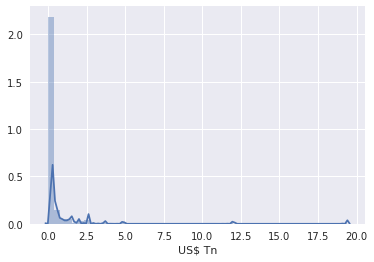

In [15]:
df_countries['US$ Tn'] = df_countries['GDP(US$MM)'].div(1000000).apply(lambda x: round(x,2))
sns.distplot(df_countries['US$ Tn'])

From this quick and not so impressive chart we see that GDP is very highly squewed and we proceed with some basic stats.

In [16]:
# basic stats

print('The max GDP value is    : $ Tn {} '.format(round(df_countries['US$ Tn'].max(), 3)))
print('The mean GDP value is   : $ Tn {} '.format(round(df_countries['US$ Tn'].mean(), 3)))
print('The median GDP value is : $ Tn {} '.format(round(df_countries['US$ Tn'].median(), 3)))
print('The total GDP value is  : $ Tn {} '.format(round(df_countries['US$ Tn'].sum(), 3)))

The max GDP value is    : $ Tn 19.39 
The mean GDP value is   : $ Tn 0.418 
The median GDP value is : $ Tn 0.03 
The total GDP value is  : $ Tn 79.75 


We continue by adding up the GDP cumulatively in a new column.

In [17]:
df_countries['Cumulative US$ Tn'] = df_countries['US$ Tn'].cumsum()

In [18]:
df_countries.head()

,Country,GDP(US$MM),US$ Tn,Cumulative US$ Tn
Rank,,,,
1,United States,19390600,19.39,19.39
2,China,12014610,12.01,31.40
3,Japan,4872135,4.87,36.27
4,Germany,3684816,3.68,39.95
5,United Kingdom,2624529,2.62,42.57


<p style="font-family: Arial; font-size:1.5em;color:red; font-style:bold"><br>
We can see that the first 4 countries in the list produce 50% of the worlds GDP...!</p><br>

Next we plot the top 40 and the bottom 40 countries in the rankings.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

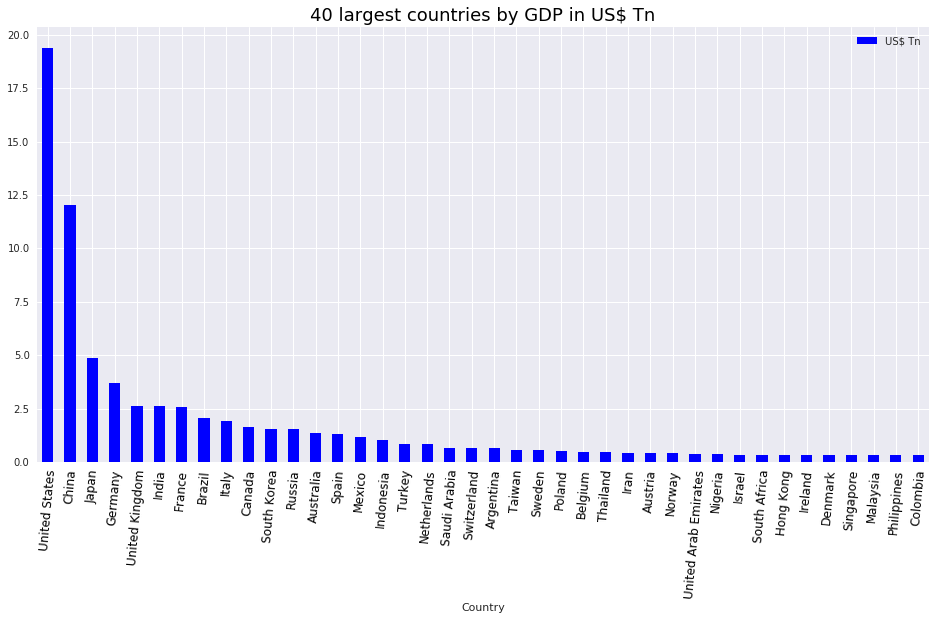

In [19]:

df_countries.iloc[:40].plot('Country', 'US$ Tn', kind='bar', color='blue', figsize=(16,8))
plt.title('40 largest countries by GDP in US$ Tn', fontsize=18, color='black')
plt.xticks(rotation=85, fontsize=12, color='black')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

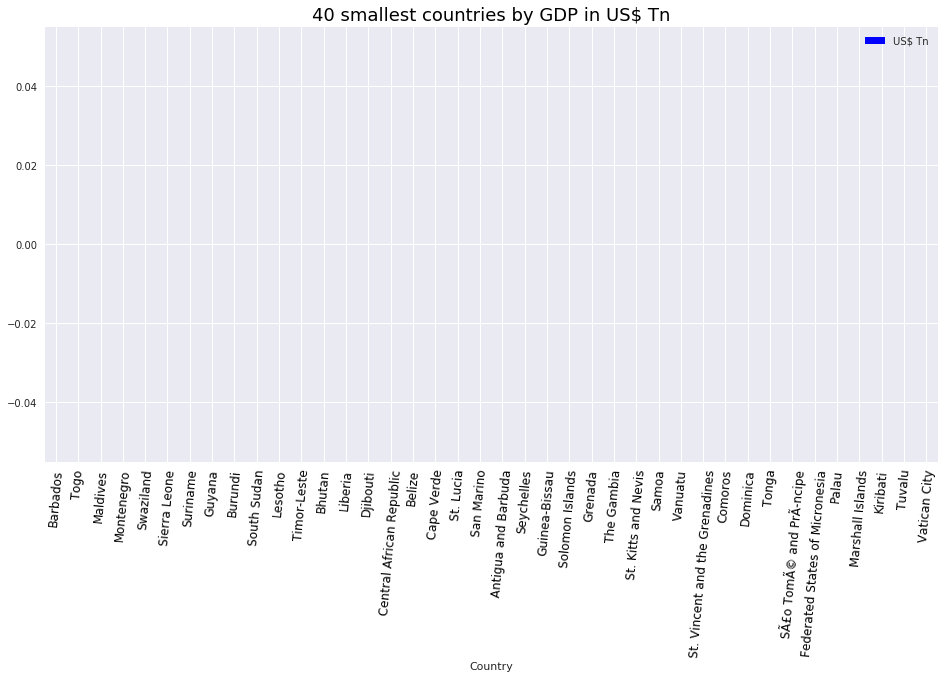

In [20]:
df_countries.iloc[-40:].plot('Country', 'US$ Tn', kind='bar', color='blue', figsize=(16,8))
plt.title('40 smallest countries by GDP in US$ Tn', fontsize=18, color='black')
plt.xticks(rotation=85, fontsize=12, color='black')

*END*

Note: a few formatting errors occur while github renders the notebook. For best results use the below link to download the global_gdp.ipynb notebook to open in Jupyter Notebook:

https://github.com/GxpMario/data_analysis